# Neural ODEs - II
We here implement, in ```heyoka```, a standard traning pipeline for NeuralODE replicating this [torcheqdiff demo](https://github.com/rtqichen/torchdiffeq/blob/master/examples/ode_demo.py).

We will be using the very same parameters and dynamics, of the original demo but only use a simple fixed learning rate stochastic gradient descent. Note that it is also possible to use more advanced optimizers such as those implemented in [pytorch](https://pytorch.org/docs/stable/optim.html) while computing the gradients using heyoka, but in this tutorial we keep it simple and just update the gradient naively.

See also:
* [Neural ODEs I](<./NeuralODEs_I.ipynb>)
* [Neural Hamiltonian ODEs](<./NeuralHamiltonianODEs.ipynb>)

In [1]:
# The main imports
import numpy as np
import time
from itertools import batched
from copy import deepcopy

# Import Heyoka
import heyoka as hy

%matplotlib inline
import matplotlib.pyplot as plt

## Generating the ground truth

The dynamics we consider is a simple third order system:

$$
\left\{
\begin{array}{l}
\dot x = -0.1 x^3 - 2y^3 \\
\dot y = 2 x^3 - 0.1y^3 
\end{array}
\right.
$$

which we implement in ``heyoka`` as follows:

In [2]:
# The symolic variables representing the system state.
x, y = hy.make_vars("x", "y")

# We now assemble the dynamics.
A = np.array([[-0.1, 2.0], [-2.0, -0.1]])
tmp = np.array([[x * x * x, y * y * y]]) @ A
dyn = [(x, tmp[0][0]), (y, tmp[0][1])]

# For convenience we store here the dimension of the state.
dim = len(dyn)

To generate groundtruth observations from this system we will use the following parameters:

In [3]:
# This is the number of observations (i.e. the ground truth).
data_size = 1000
# This is the initial condition used to generate the observations (i.e. the ground truth).
ic = [2.0, 0.0]
# This is the time grid used to generate the observations (i.e. the ground truth).
t_grid = np.linspace(0.0, 25, data_size)

We start by instantiating a ``heyoka.taylor_adaptive`` object that will generate our observations. These will be considered as ground truth. Note that in other settings this data may be observed from a real phenomena, rather than generated numerically. In that case there will be noise which is here not modelled.

In [ ]:
start_time = time.time()
ta = hy.taylor_adaptive(
    # The ODEs.
    dyn,
    # The initial conditions.
    ic,
    # Do not operate in compact mode.
    compact_mode=False,
    # Define the tolerance.
    tol=1e-18,
)
print(
    "--- %s seconds --- to build (jit) the Taylor integrator"
    % (time.time() - start_time)
)

--- 0.16298365592956543 seconds --- to build (jit) the Taylor integrator


We are thus ready to generate the the ground truth using the method ``propagate_grid`` method of the Taylor adaptive integrator.

In [ ]:
# It is good practice to always set initial conditions explicitly.
ta.time = 0
ta.state[:] = ic
# This is our ground truth (gt).
gt = ta.propagate_grid(t_grid)[5]

Let us have a look at the generated observations.

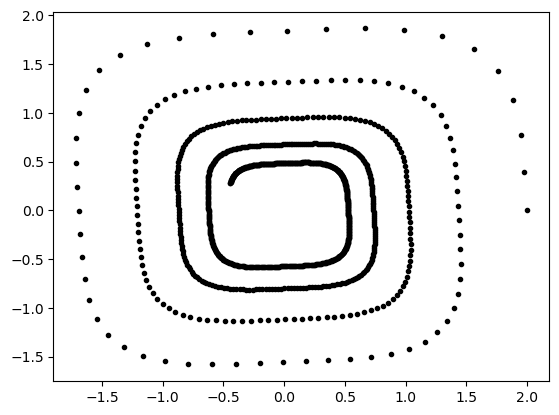

In [6]:
plt.plot(gt[:, 0], gt[:, 1], "k.")

## Instantiating the neural ODE

So far we have only generated the data we want to teach our Neural ODE to replicate. We now need to instantiate the Neural ODE system so that we can make predictions and compute the gradient of our loss.
Let us start with instantiating a feed-forward neural network using ``heyoka.models.ffnn``.

In [ ]:
# We define as nonlinearity a simple linear layer.
linear = lambda inp: inp

# We call the factory to construct a FFNN. Following the torcheqdiff example,
# here we put cubes as inputs:
ffnn = hy.model.ffnn(
    inputs=[x * x * x, y * y * y],
    nn_hidden=[50],
    n_out=2,
    activations=[hy.tanh, linear],
)

We are now able to build a {class}`~heyoka.taylor_adaptive_batch` numerical integrator which will propagate the dynamics in batches as to leverage SIMD instructions:

$$
\left\{
\begin{array}{l}
\dot x = \mathcal N_{\theta, x}(x^3, y^3) \\
\dot y = \mathcal N_{\theta, y}(x^3, y^3) \\
\end{array}
\right.
$$

And since we will want to be able to compute the sensitivities of this ODE we are first going to augment such dynamics with the first order variational equations:

In [ ]:
# We decide on whether to use single or double precision. In this example it may
# not be too important, but in other settings it can give a speedup when connected
# with batch and ensemble propagation. The single precision does affect, though,
# the quality of the gradient direction.
precision = np.double  # np.single
batch_size_simd = hy.recommended_simd_size(fp_type=precision)
print("Batch size for SIMD use in integration: ", batch_size_simd)

# We thus define the neural dynamics.
dyn_n = [(x, ffnn[0]), (y, ffnn[1])]

# We augment it with the variational one (only order 1 - i.e., gradient).
var_dyn_n = hy.var_ode_sys(dyn_n, args=hy.var_args.params, order=1)

Batch size for SIMD use in integration:  4


... and instantiate the variational integrator. For convenience we also instantiate the non batched version

In [ ]:
# This is the batched version, which we will use for gradient computation.
ta_var_b = hy.taylor_adaptive_batch(
    # The ODEs.
    var_dyn_n,
    # The initial conditions.
    np.ones((dim, batch_size_simd), dtype=precision),
    # Operate in compact mode.
    compact_mode=True,
    # Define the tolerance (low tolerance is enough here).
    tol=precision(1e-4),
    # Single precision is enough here.
    fp_type=precision,
)

# This is the normal version used for quick plotting and visualization of a single solution.
ta_var = hy.taylor_adaptive(
    # The ODEs.
    var_dyn_n,
    # The initial conditions.
    ic,
    # Operate in compact mode.
    compact_mode=True,
    # Define the tolerance (low tolerance is enough here).
    tol=precision(1e-4),
    # Single precision is enough here.
    fp_type=precision,
)

# We store for convenience the initial conditions in a numpy array (including the variational state).
ic_var_b = np.array(ta_var_b.state)
ic_var = np.array(ta_var.state)

Before starting the training, we define the details on the batch we are going to use in the generic step of stochastic gradient descent:

In [ ]:
# This is the number of initial conditions to use in one batch (M).
batch_size_ic = 20
# This is the number of observations to predict from each sampled initial condition (T).
batch_size_time = 10
# We check that the observation batch size is a multiple of the simd batch size.
print("This must be an integer: ", batch_size_ic / batch_size_simd)

This must be an integer:  5.0


This helper function creates a randomly generated batch from the available observation:

In [ ]:
def get_batch(t_grid, gt, batch_size_ic=20, batch_size_time=10):
    # We select the initial conditions from which to generate predictions.
    s = np.random.choice(
        np.arange(gt.shape[0] - batch_size_time, dtype=np.int64),
        batch_size_ic,
        replace=False,
    )
    batch_ic = gt[s, :]  # (M, D)
    # Assuming uniform grid and a non-autonomous system, all predictions will
    # be made on the same time grid.
    batch_t_grid = t_grid[:batch_size_time]  # (T)
    batch_y = np.stack([gt[s + i] for i in range(batch_size_time)])  # (T,M,D)
    return batch_ic, batch_t_grid, batch_y

Let us visualize what a batch looks like. First we generate one:

In [ ]:
batch_ic, batch_t_grid, batch_y = get_batch(t_grid, gt, batch_size_ic, batch_size_time)

# We need the tgrid repeated as per heyoka API of the taylor adaptive batch.
t_grid_b = np.repeat(batch_t_grid, batch_size_simd).reshape(-1, batch_size_simd)

Then we plot it overlapped to all the observations:

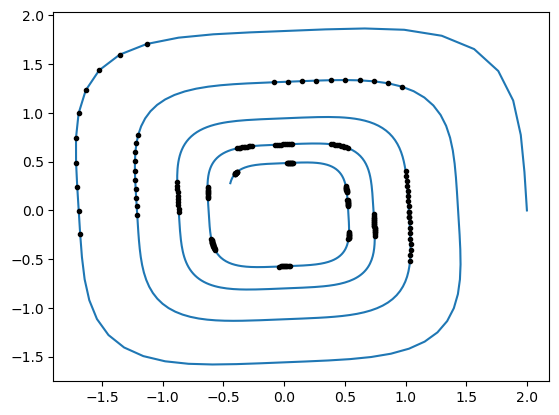

In [13]:
plt.plot(gt[:, 0], gt[:, 1])
for i in range(batch_size_ic):
    plt.plot(batch_y[:, i, 0], batch_y[:, i, 1], "k.")

We initialize the network weights and biases.

In [ ]:
# We compute initialization values for weigths / biases.
n_pars = len(ta_var_b.pars)
nn_wb = np.random.normal(loc=0, scale=0.1, size=(n_pars,))

And visualize the prediction of the starting random network.

--- 0.015778303146362305 seconds --- to compute prediction over the whole batch


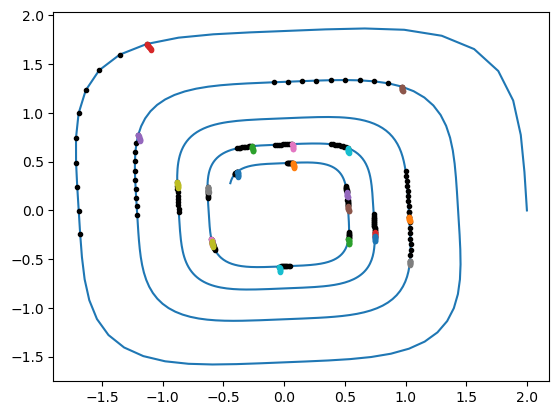

In [15]:
plt.plot(gt[:, 0], gt[:, 1])
for i in range(batch_size_ic):
    plt.plot(batch_y[:, i, 0], batch_y[:, i, 1], "k.")

start_time = time.time()
for batch in batched(batch_ic, batch_size_simd):
    ta_var_b.set_time(precision(0.0))
    ta_var_b.state[:, :] = deepcopy(ic_var_b)
    ta_var_b.state[:dim, :] = np.array(batch).T
    ta_var_b.pars[:] = np.tile(nn_wb, (batch_size_simd, 1)).T
    sol_b = ta_var_b.propagate_grid(np.array(t_grid_b, dtype=precision))[1]
    for sol in [sol_b[:, :, i] for i in range(batch_size_simd)]:
        plt.plot(sol[:, 0], sol[:, 1], ".")
print(
    "--- %s seconds --- to compute prediction over the whole batch"
    % (time.time() - start_time)
)

## Training

To train we need to first compute the gradient of the loss over the batch (M initial conditions and T times). Formally

$$
\mathcal L_{\theta} = \sum_{i=0}^{M}\sum_{j=0}^T (\pmb y_{ij} - \hat {\pmb y}_{ij})\cdot (\pmb y_{ij} - \hat {\pmb y}_{ij})
$$

$$
\frac{\partial L_\theta}{\partial \theta} =  2 \sum_{i=0}^{M}\sum_{j=0}^T (\pmb y_{ij} - \hat {\pmb y}_{ij})\cdot \frac{\partial \pmb y_{ij}}{\partial \theta}
$$
This helper function computes the loss and the gradient over one batch. The gradient is computed rearranging the ODE sensitivities computed propagating the variational dynamics:

In [ ]:
def loss_and_gradient(nn_wb, batch_ic, batch_y):
    # We reset the batch_loss value.
    batch_loss = 0
    # We reset the gradient loss.
    grad = np.array([0.0] * ta_var_b.pars.shape[0])
    counter = 0
    # We process the batch (of the dataset) in batches for SIMD efficient processing.
    for batch_simd in batched(batch_ic, batch_size_simd):
        ta_var_b.set_time(precision(0.0))
        ta_var_b.state[:, :] = deepcopy(ic_var_b)
        ta_var_b.state[:dim, :] = np.array(batch_simd).T
        ta_var_b.pars[:] = np.tile(nn_wb, (batch_size_simd, 1)).T
        sol_b = ta_var_b.propagate_grid(np.array(t_grid_b, dtype=precision))[1]
        # The numerical integration on the simd_batch is done, we process its result
        # accumulating loss and gradient on the predictions.
        for sol in [sol_b[:, :, i] for i in range(batch_size_simd)]:
            # Here is the term (y-y_hat).
            diff = sol[:, :dim] - batch_y[:, counter, :]
            counter += 1
            # Which is then summed sum sum (y-y_hat).(y-y_hat).
            batch_loss += np.sum(diff**2)
            # And the gradient computed as 2 sum (y-y_hat).dy.
            for dy in sol[:, dim:].reshape(batch_y.shape[0], dim, -1):
                grad += 2 * np.sum(diff @ dy, axis=0)
    # We then take the mean over the points used.
    batch_loss /= batch_size_ic * batch_size_time
    grad /= batch_size_ic * batch_size_time
    return batch_loss, grad

Using the various blocks defined above the training loop takes the form:

In [ ]:
# We reset initialization values for weigths / biases.
n_pars = len(ta_var_b.pars)
nn_wb = np.random.normal(loc=0, scale=0.1, size=(n_pars,))

In [ ]:
# We loop over the epochs.
n_epochs = 3000
start_time = time.time()
for i in range(n_epochs):
    # 1 - generate a batch
    batch_ic, batch_t_grid, batch_y = get_batch(
        t_grid, gt, batch_size_ic=batch_size_ic, batch_size_time=batch_size_time
    )
    # 2 - compute the loss and gradient on the batch.
    batch_loss, grad = loss_and_gradient(nn_wb, batch_ic, batch_y)
    print(f"iter: {i}, loss : {batch_loss:.3e}", end="\r")
    # 3 - update the weights and biases (learning rate here is fixed, we use a naive
    # update rule which in this case works).
    nn_wb = nn_wb - 0.1 * grad
print(f"iter: {i}, loss : {batch_loss:.3e}", end="\n")
print("--- %s seconds --- to perform %i epochs" % (time.time() - start_time, n_epochs))

iter: 2999, loss : 1.385e-04
--- 27.929445266723633 seconds --- to perform 3000 epochs


**NOTE**: For comparison we also called the [torcheqdiff demo](https://github.com/rtqichen/torchdiffeq/blob/master/examples/ode_demo.py) using the following command line 'python ode_demo.py --niters 3000'. This triggers a comparable number of gradient evaluations on CPU. The iterations done in `torcheqdiff` complete in **348 seconds** showing how on common CPUs, the use of ``heyoka`` may offer a significant speedup for NeuralODE research.

We are now ready to visualize the result of the learned neural ODE:

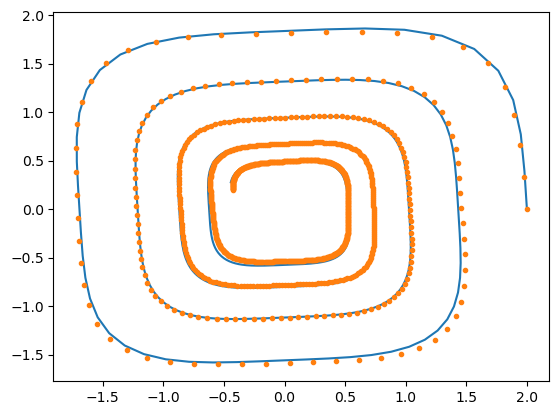

In [22]:
plt.plot(gt[:, 0], gt[:, 1])

ta_var.time = precision(0)
ta_var.state[:] = list(ic_var)
ta_var.state[:2] = ic
ta_var.pars[:] = np.array(nn_wb, dtype=np.single)
sol = ta_var.propagate_grid(np.array(t_grid, dtype=precision))[5]
plt.plot(sol[:, 0], sol[:, 1], ".")

It is also of interest to visualize the predictions of the trained system over a new random batch, as opposed to the predictions of the entire trajectory from the first observation:

--- 0.016167402267456055 seconds --- to compute prediction over the whole batch


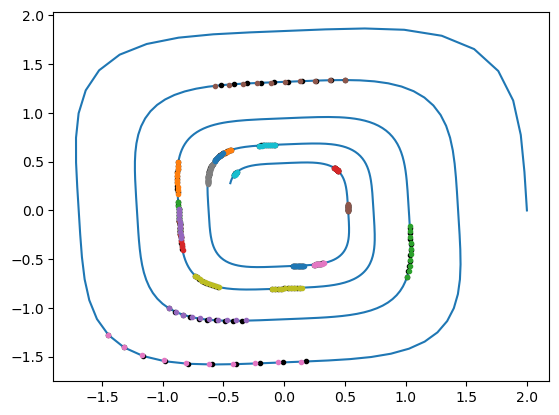

In [23]:
batch_ic, batch_t_grid, batch_y = get_batch(t_grid, gt, batch_size_ic, batch_size_time)

plt.plot(gt[:, 0], gt[:, 1])
for i in range(batch_size_ic):
    plt.plot(batch_y[:, i, 0], batch_y[:, i, 1], "k.")

start_time = time.time()
for batch in batched(batch_ic, batch_size_simd):
    ta_var_b.set_time(precision(0.0))
    ta_var_b.state[:, :] = deepcopy(ic_var_b)
    ta_var_b.state[:dim, :] = np.array(batch).T
    ta_var_b.pars[:] = np.tile(nn_wb, (batch_size_simd, 1)).T
    sol_b = ta_var_b.propagate_grid(np.array(t_grid_b, dtype=precision))[1]
    for sol in [sol_b[:, :, i] for i in range(batch_size_simd)]:
        plt.plot(sol[:, 0], sol[:, 1], ".")
print(
    "--- %s seconds --- to compute prediction over the whole batch"
    % (time.time() - start_time)
)